# Running State Arrays on SMALL-LABS formatted data

## Setup environment

In [28]:
!pip install saspt

## Imports

In [43]:
from glob import glob
import logging
from os.path import join
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib_scalebar.scalebar as sb
import numpy as np
from numpy.linalg import matrix_power
import pandas as pd
import scipy.io
from skimage.measure import find_contours, regionprops

from saspt import sample_detections, StateArray, StateArrayDataset, RBME
from saspt.lik import RBMELikelihood
import biteen_utilities as bu

In [44]:
%load_ext autoreload
%autoreload 2

logging.getLogger('matplotlib.font_manager').disabled = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

### Find fits files

In [5]:
fits_folder = r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\State Arrays\Lauren"
fits_pattern = r"*_fits.mat"
fits_files = glob(join(fits_folder, r"*_fits.mat"))

print("{} fits files found!".format(len(fits_files)))

21 fits files found!


### Find phase masks (labels)

In [7]:
labels_folder = r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\State Arrays\Lauren"
labels_pattern = r"*_PhaseMask.mat"
labels_files = glob(join(labels_folder, labels_pattern))

print("{} labels files found!".format(len(labels_files)))

21 labels files found!


### Read fits and labels

In [8]:
fits_list = []
labels_list = []

max_track_id = 0
max_label_id = 0

for i, (ff, lf) in enumerate(zip(fits_files, labels_files)):
    fits_curr = bu.slfile_to_df(ff) # converts SMALL-LABS to pandas DataFrame
    fits_curr['movie #'] = i

    track_ids = fits_curr['track_id'].dropna().unique()
    n_tracks = len(track_ids)
    new_track_ids = np.arange(n_tracks) + max_track_id
    max_track_id = new_track_ids[-1] + 1
    fits_curr['track_id_unique'] = fits_curr['track_id'].replace(track_ids, new_track_ids)

    label_ids = fits_curr['roinum'].dropna().unique()
    n_labels = len(label_ids)
    new_label_ids = np.arange(n_labels) + max_label_id
    max_label_id = new_label_ids[-1] + 1
    fits_curr['roinum_unique'] = fits_curr['roinum'].replace(label_ids, new_label_ids)
    
    fits_list.append(fits_curr)
    labels_list.append(scipy.io.loadmat(lf)['PhaseMask'])

    print("Load data for {} and {}".format(ff, lf))

# Aggregate fits into single DataFrame
fits_all = pd.concat(fits_list, ignore_index=True)

Load data for T:\MIGRATED\Lab_Members\Daniel_Foust\Data\State Arrays\Lauren\230210_cwx2695_2_5hr_001_AccBGSUB_fits.mat and T:\MIGRATED\Lab_Members\Daniel_Foust\Data\State Arrays\Lauren\230210_cwx2695_2_5hr_001_PhaseMask.mat
Load data for T:\MIGRATED\Lab_Members\Daniel_Foust\Data\State Arrays\Lauren\230210_cwx2695_2_5hr_002_AccBGSUB_fits.mat and T:\MIGRATED\Lab_Members\Daniel_Foust\Data\State Arrays\Lauren\230210_cwx2695_2_5hr_002_PhaseMask.mat
Load data for T:\MIGRATED\Lab_Members\Daniel_Foust\Data\State Arrays\Lauren\230210_cwx2695_2_5hr_003_AccBGSUB_fits.mat and T:\MIGRATED\Lab_Members\Daniel_Foust\Data\State Arrays\Lauren\230210_cwx2695_2_5hr_003_PhaseMask.mat
Load data for T:\MIGRATED\Lab_Members\Daniel_Foust\Data\State Arrays\Lauren\230210_cwx2695_2_5hr_004_AccBGSUB_fits.mat and T:\MIGRATED\Lab_Members\Daniel_Foust\Data\State Arrays\Lauren\230210_cwx2695_2_5hr_004_PhaseMask.mat
Load data for T:\MIGRATED\Lab_Members\Daniel_Foust\Data\State Arrays\Lauren\230210_cwx2695_2_5hr_005_Acc

## Clean up data

### Exclude bad fits

In [9]:
fits_all = fits_all[fits_all['goodfit']==True]

### Exclude short tracks

In [10]:
fits_all = bu.filter_by_nlocs(fits_all,
                              min_locs=6,
                              max_locs=np.inf,
                              track_col='track_id')

## Calculate State Array

### Rename some columns
saspt expects columns with specific names. We change SMALL-LABS column labels to labels accepted by saspt.

In [14]:
fits_sa = fits_all.rename(columns={'col': 'x', 
                                   'row': 'y', 
                                   'track_id_unique': 'trajectory'})

### Define State Array

In [15]:
settings = dict(
    likelihood_type = RBME, # model that includes Brownian motion and localization error
    pixel_size_um = 0.049,  
    frame_interval = 0.04,  # in seconds
    focal_depth = np.inf,   # maybe should play around with this
    progress_bar = True,
)

SA = StateArray.from_detections(fits_sa[['x', 'y', 'trajectory', 'frame']], **settings)

# can ignore SettingWithCopyWarning

c:\Users\djfoust\Anaconda3\envs\saspt_env\lib\site-packages\saspt\trajectory_group.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections[cls.DETECT_INDEX] = np.arange(len(detections), dtype=np.int64)


### Overwrite default likelihood model

In [19]:
rbme_likelihood = RBMELikelihood(
    pixel_size_um = 0.049,
    frame_interval = 0.04,
    focal_depth = np.inf,
    diff_coefs = np.logspace(-3, 1, 100), # adjust diffusion coefficients to consider here
    loc_errors = np.linspace(0, 0.1, 30)  # adjust localization errors to consider here
    )

SA.likelihood = rbme_likelihood

### Calculate State Arrays

In [20]:
SA.posterior_assignment_probabilities;

inferring posterior distribution...


100%|██████████| 200/200 [00:27<00:00,  7.32it/s]


## Secondary calculations

### Posterior occupancy marginalized on diffusion coefficient

In [23]:
postoccs_all = SA.posterior_occs.sum(axis=1)
print(postoccs_all.shape)

(100,)


### Occupancy by label

In [186]:
sa_detections = SA.trajectories.detections
fits_all.loc[sa_detections['detect_index'], 'track_id_SA'] = sa_detections['trajectory']

postoccs_labels = []

for label in fits_all['roinum_unique'].unique():
    track_ids_label = fits_all[fits_all['roinum_unique']==label]['track_id_SA'].dropna().unique().astype('int')
    postoccs_labels.append((postoccs_tracks[:,track_ids_label] 
                      * SA.jumps_per_track[track_ids_label]).sum(axis=1) 
                      / SA.jumps_per_track[track_ids_label].sum())
    
postoccs_labels = np.array(postoccs_labels).T

### Average diffusion coefficient for each track

In [27]:
postoccs_tracks = SA.posterior_assignment_probabilities.sum(axis=1) # for each individual track, marginalized on diffusion coefficient
Dav_track = (postoccs_tracks * SA.diff_coefs[:,None]).sum(axis=0)

sa_detections['D_av'] = Dav_track[sa_detections['trajectory']]
print('num_diff_coef: {}, num_tracks: {}'.format(*postoccs_tracks.shape))

num_diff_coef: 100, num_tracks: 6413


### Diffusion coefficient at peak position

In [141]:
idx_D_max = np.argmax(postoccs_tracks, axis=0)
D_max = diff_coefs[idx_D_max]

sa_detections['idx_D_max'] = idx_D_max[sa_detections['trajectory']]
sa_detections['D_max'] = D_max[sa_detections['trajectory']]

### Merge SA results with original data

In [113]:
fits_all['track_id_SA'] = np.nan
# fits_all.loc[sa_detections['detect_index'], 'track_id_SA'] = sa_detections['trajectory']
fits_all.loc[sa_detections['detect_index'], 'D_av'] = sa_detections['D_av']
fits_all.loc[sa_detections['detect_index'], 'idx_D_max'] = sa_detections['idx_D_max']
fits_all.loc[sa_detections['detect_index'], 'D_max'] = sa_detections['D_max']

fits_all['log10(D_av)'] = np.log10(fits_all['D_av'])

## Plotting

### Setup color map

In [29]:
def linear_ramp_cmap(cmap=mpl.cm.cool, vmin=0, vmax=1, lmin=0.25, lmax=0.75, name='lr_cmap'):
    """
    Color is constant (min) between vmin and lmin, follows cmap between lmin and lmax, and constant (max) between lmax and vmax.

    Parameters
    ----------
    

    Returns
    -------

    """
    x = np.linspace(0, 1, 256)
    n_min = len(x[x<(lmin-vmin) / (vmax - vmin)])
    n_max = len(x[x>(lmax-vmin) / (vmax - vmin)])

    seg1 = np.array(n_min * [cmap(0.),])
    seg2 = cmap(np.linspace(0, 1, 256-n_min-n_max))
    seg3 = np.array(n_max * [cmap(1.),])

    colors = np.vstack((seg1, seg2, seg3))

    lr_cmap = mpl.colors.ListedColormap(colors=colors, N=256, name=name)

    return lr_cmap

In [31]:
coolramp = linear_ramp_cmap(cmap=mpl.cm.cool, vmin=-3, vmax=1, lmin=-2, lmax=0, name='coolramp')

In [32]:
diff_coefs = SA.diff_coefs

### Overall posterior occupancy

In [129]:
locs_per_track = np.array([len(fits_all['track_id_SA']==-tid) for tid in fits_all['track_id_SA'].dropna().unique()])

In [134]:
postoccs_all_by_locs = (postoccs_tracks * locs_per_track).sum(axis=1) / locs_per_track.sum()

In [189]:
def plot_occs(diff_coefs,
              occs,
              suboccs=None,
              cmap=None,
              figprops={'figsize': (4,4)},
              lineprops={'color': 'xkcd:black', 'lw': 3},
              sublineprops={'color': 'xkcd:grey', 'lw': 1.5, 'alpha': 0.1},
              labelsize=14,
              ax=None):
    """

    
    Parameters
    ----------

    
    Returns
    -------

    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, **figprops)

    if suboccs is not None:
        ax.plot(diff_coefs, suboccs, **sublineprops)
    ax.plot(diff_coefs, occs, **lineprops)
    ax.set_xscale('log')
    ax.set_xlim(left=diff_coefs[0], right=diff_coefs[-1])
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Occupation', fontsize=labelsize)

    if cmap is not None:
        ax.set_xticks([]) # hide default ticks
        norm = mpl.colors.LogNorm(vmin=diff_coefs[0], vmax=diff_coefs[-1])
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=coolramp)
        cbar = plt.colorbar(
            sm,
            orientation='horizontal',
            ticks=10**np.arange(np.floor(np.log10(diff_coefs[0])), np.ceil(np.log10(diff_coefs[-1]))+1),
            ax=ax,
            label='$D_{app}\ (\mu m^2/s)$',
            pad=0
            )
        cbar.solids.set(alpha=1) # force alpha=1
        xticklabels = ['$\\mathdefault{10^{'+str(num)+'}}$' for num in np.arange(
            np.floor(np.log10(diff_coefs[0])),
            np.ceil(np.log10(diff_coefs[-1]))+1,
            dtype='int'
            )]
        cbar.ax.set_xticklabels(xticklabels)
        cbar.set_label(r'$D_{app}\ (\mu m^2/s)$', fontsize=labelsize)
    else:
        ax.set_xlabel(r'$D_{app}\ (\mu m^2/s)$', fontsize=labelsize)
    ;
    return fig, ax

(<Figure size 400x400 with 2 Axes>, <Axes: ylabel='Occupation'>)

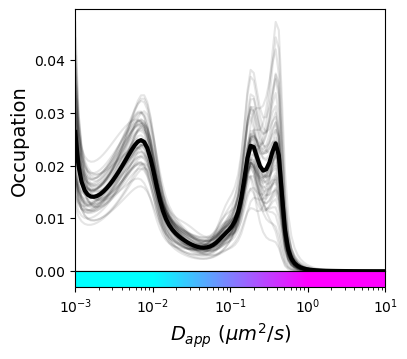

In [193]:
plot_occs(diff_coefs,
          postoccs_all,
          suboccs=postoccs_labels,
          cmap=coolramp,
          sublineprops={'lw': 1.5, 'color': 'xkcd:black', 'alpha': 0.1})

In [262]:
def plot_occs_w_fill(diff_coefs,
              occs,
              ranges,
              colors,
              figprops={'figsize': (4,4)},
              lineprops={'color': 'xkcd:black', 'lw': 3},
              labelsize=14,
              ax=None):
    """

    
    Parameters
    ----------

    
    Returns
    -------

    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, **figprops)

    focc = interp1d(diff_coefs, occs)

    for i, (l, h) in enumerate(ranges):
        diff_filt = (diff_coefs >= l) & (diff_coefs < h)
        diff_coefs_range = np.concatenate(([l],
                                           diff_coefs[diff_filt],
                                           [h]))
        occs_range = np.concatenate(([focc(l)],
                                     occs[diff_filt], 
                                     [focc(h)]))
        poly = ax.fill_between(x=diff_coefs_range, y1=occs_range, color=colors[i])
        print(poly)
        (x0, y0), (x1, y1) = poly.get_paths()[0].get_extents().get_points()
        w = occs[diff_filt].sum()
        t = ax.text(np.median(diff_coefs_range), #(x0 + x1) / 2,
                (y0 + y1) / 2, 
                "{:.2f}".format(w), 
                ha='center', 
                va='center', 
                fontsize=14, 
                color='xkcd:black')
        t.set_bbox({'facecolor': 'xkcd:white', 'alpha': 0.5, 'edgecolor': 'none'})
    ax.plot(diff_coefs, occs, **lineprops)
    ax.set_xscale('log')
    ax.set_xlim(left=diff_coefs[0], right=diff_coefs[-1])
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Occupation', fontsize=labelsize)
    ax.set_xlabel(r'$D_{app}\ (\mu m^2/s)$', fontsize=labelsize)

    return fig, ax

In [239]:
help(ax.text)

Help on method text in module matplotlib.axes._axes:

text(x, y, s, fontdict=None, **kwargs) method of matplotlib.axes._axes.Axes instance
    Add text to the Axes.
    
    Add the text *s* to the Axes at location *x*, *y* in data coordinates.
    
    Parameters
    ----------
    x, y : float
        The position to place the text. By default, this is in data
        coordinates. The coordinate system can be changed using the
        *transform* parameter.
    
    s : str
        The text.
    
    fontdict : dict, default: None
    
        .. admonition:: Discouraged
    
           The use of *fontdict* is discouraged. Parameters should be passed as
           individual keyword arguments or using dictionary-unpacking
           ``text(..., **fontdict)``.
    
        A dictionary to override the default text properties. If fontdict
        is None, the defaults are determined by `.rcParams`.
    
    Returns
    -------
    `.Text`
        The created `.Text` instance.
    
   

In [204]:
from scipy.interpolate import interp1d

In [205]:
interp1d(diff_coefs, postoccs_all)

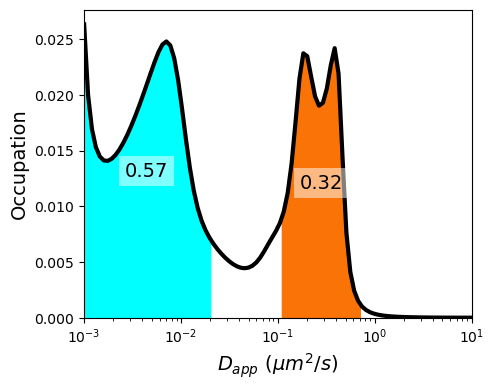

In [263]:
fig, ax = plot_occs_w_fill(diff_coefs,
              postoccs_all,
              ranges=((1e-3, 2e-2), (1.1e-1, 7e-1)),
              colors=('xkcd:cyan', 'xkcd:orange'),
              figprops={'figsize': (5,4)},
              lineprops={'color': 'xkcd:black', 'lw': 3},
              labelsize=14,
              ax=None);

# ax.annotate('10%', xy=(2*1e-3, 0.001), fontsize=12)

In [258]:
bb = ax.bbox

In [261]:
bb.

array([[ 62.5,  44. ],
       [450. , 352. ]])

In [ ]:
diff_coefs = SA.diff_coefs

figures_list = []

default_scalebar_props = {
    'dx': 0.049,
    'units': 'um',
    'fixed_value': 2,
    'scale_loc': 'none',
    'location': 'lower right',
    'frameon': False,
    'color': 'xkcd:white'
}

for imov in fits_all['movie #'].unique():
    movie_fits = all_fits[all_fits['movie #']==imov]
    movie_fits = movie_fits[~np.isnan(movie_fits['track_id_SA'])]
    movie_track_posteriors = track_posteriors[:, movie_fits['track_id_SA'].unique().astype('int')]

    movie_posterior_occs = (movie_track_posteriors * movie_fits.groupby('track_id_SA')['track_id_SA'].count().values).sum(axis=1) / len(movie_fits)

    phase_mask = phase_masks[imov]
    contours = bu.labels_to_contours(phase_mask, level=0.9)
    contours = [[smooth_polygon(contour[0])] for contour in contours]

    fig, ax = plt.subplots(2,1, figsize=(4,8))
    fig.suptitle(Path(files[imov]).stem, fontsize=12, y=0.92)
    ax[0].set_xscale('log')
    ax[0].set_xlim(left=diff_coefs[0], right=diff_coefs[-1])
    ax[0].set_ylim(bottom=0, top=movie_track_posteriors.max()*1.05)
    ax[0].plot(diff_coefs, movie_track_posteriors,
               color='xkcd:grey',
               lw=1.5,
               alpha=0.1)
    ax[0].plot(diff_coefs, movie_posterior_occs,
               color='xkcd:black',
               lw=3)
    ax[0].set_ylabel('Occupation', fontsize=14)
    
    ax[1].imshow(np.zeros(phase_mask.shape), cmap='binary_r')
    bu.crop_to_labels(ax[1], phase_mask)
    ax[1].set_axis_off()
    for contour in contours:
        ax[1].plot(contour[0][:,1], contour[0][:,0], lw=1, alpha=0.5, color='xkcd:gray')
    scatmap = ax[1].scatter(
        data=movie_fits.sort_values('D_av', ascending=False),
        # data=movie_fits,
        x='col',
        y='row',
        c='D_av',
        edgecolor='none',
        vmin=1e-3,
        vmax=1e1,
        alpha=0.33,
        s=5,
        cmap=coolramp,
        norm='log')
    ax[0].set_xticks([])
    cbar = plt.colorbar(scatmap,
                        orientation='horizontal',
                        ticks=[1e-3, 1e-2, 1e-1, 1e0, 1e1],
                        ax=ax[0],
                        label=r'$D_{app}\ (\mu m^2/s)$',
                        pad=0)
    
    cbar.solids.set(alpha=1)
    # cbar.set_label(fontsize=14)
    cbar.ax.set_xticklabels(['$\\mathdefault{10^{-3}}$',
                             '$\\mathdefault{10^{-2}}$',
                             '$\\mathdefault{10^{-1}}$',
                             '$\\mathdefault{10^{0}}$',
                             '$\\mathdefault{10^{1}}$'])
    # cbar.ax.tick_params(axis='x', labelsize=18)
    cbar.set_label(r'$D_{app}\ (\mu m^2/s)$', fontsize=14)
    
    scalebar = sb.ScaleBar(**default_scalebar_props)
    ax[1].add_artist(scalebar)
        
    all_figures.append(fig)